In [8]:
import torch
import gradientUtils as gu
# Define a threshold for early stopping
threshold = 1e-10
circle_center = torch.tensor([5.0, 5.0])  # Example circle center
radius = 3.0  # Example radius
alpha = 0.1  # Learning rate
delta = 1e-5

In [9]:
circle_center = torch.tensor([0.0, 0.0])  # Example circle center
radius = 1.0  # Example radius
true_loss_values = []

# Initialize the source points (p1, p2, p3) as PyTorch tensors
p1 = torch.tensor([1.0, 1.0], requires_grad=True)
p2 = torch.tensor([3.0, 1.0], requires_grad=True)
p3 = torch.tensor([3.0, 3.0], requires_grad=True)
destination = "images/autograd/cccsdf/"
prev_loss = float("inf")


# Define the optimizer
optimizer = torch.optim.Adam([p1, p2, p3], lr=0.1)

# Optimization loop
for step in range(100000):
    optimizer.zero_grad()
    
    # Compute the point (x, y) from the source points and weights
    x,y = gu.compute_vertex(p1, p2, p3)
    
    # Calculate the SDF value at the current point
    vertex_loss = gu.circle_sdf(x,y, circle_center, radius)**2
    print(f'Vertex Loss: {vertex_loss.item()}')
    # Calculate the SDF values of the midpoints
    midpoint_loss = gu.midpoint_loss_sdf(p1, p2, p3, circle_center, radius)
    # Define the loss as the squared distance
    loss = vertex_loss + 0.05 * midpoint_loss
    
    # Early stopping condition
    if abs(prev_loss - loss.item()) < threshold:
        print(f"Stopping early at epoch {step} due to minimal loss change")
        gu.plot_and_save(
            step, p1, p2, p3, circle_center, radius, destination=destination
        )
        break

    prev_loss = loss.item()
    # Backpropagation
    loss.backward()
    
    # Optimization step
    optimizer.step()
    
    # Print progress every 100 steps
    if step % 10 == 0:
        print(f'Step {step}, Point: {x.item(),y.item()}, Loss: {loss.item()}, distance: {vertex_loss.item()}')
        gu.plot_and_save(step, p1, p2, p3,circle_center, radius, destination=destination)
        true_loss_values.append(loss.item())



# Final optimized point
x,y = gu.compute_vertex(p1, p2, p3)
print(f'Optimized Point: {x.item(),y.item()}')
print(f'Optimized p1: {p1.detach().numpy()}')
print(f'Optimized p2: {p2.detach().numpy()}')
print(f'Optimized p3: {p3.detach().numpy()}')
gu.plot_and_save(step, p1, p2, p3, circle_center, radius, destination=destination)




Vertex Loss: 3.3431456089019775
Step 0, Point: (2.0, 2.0), Loss: 3.758983612060547, distance: 3.3431456089019775
Vertex Loss: 2.845989942550659
Vertex Loss: 2.3900976181030273
Vertex Loss: 1.9760459661483765
Vertex Loss: 1.6041556596755981
Vertex Loss: 1.274456262588501
Vertex Loss: 0.9866272807121277
Vertex Loss: 0.7399476170539856
Vertex Loss: 0.5332499146461487
Vertex Loss: 0.36486825346946716
Vertex Loss: 0.23261310160160065
Vertex Loss: 0.13376012444496155
Vertex Loss: 0.06506738066673279
Vertex Loss: 0.02282898873090744
Vertex Loss: 0.0029675590340048075
Vertex Loss: 0.001163313863798976
Vertex Loss: 0.013012263923883438
Vertex Loss: 0.03419741615653038
Vertex Loss: 0.060647327452898026
Vertex Loss: 0.08864114433526993
Vertex Loss: 0.11478964984416962
Vertex Loss: 0.13578443229198456
Vertex Loss: 0.1479276418685913
Vertex Loss: 0.14719733595848083
Vertex Loss: 0.131193608045578
Vertex Loss: 0.10182049125432968
Vertex Loss: 0.06565549224615097
Vertex Loss: 0.03167959675192833
Vert

In [10]:
circle_center = torch.tensor([0.0, 0.0])  # Example circle center
radius = 1.0  # Example radius
mp_lambda = 0.05
threshold = 1e-10

# Initialize the source points (p1, p2, p3) as PyTorch tensors
p1 = torch.tensor([1.0, 1.0], requires_grad=True)
p2 = torch.tensor([3.0, 1.0], requires_grad=True)
p3 = torch.tensor([3.0, 3.0], requires_grad=True)
destination = "images/autograd/sdf_interpol/"
prev_loss = float("inf")

interpolated_vertex_values = []
true_vertex_values = []
interpolated_loss_values = []



# Define the optimizer
optimizer = torch.optim.Adam([p1, p2, p3], lr=0.1)

# Optimization loop
for step in range(100000):
    optimizer.zero_grad()
    
    sdf_p1 = gu.circle_sdf(p1[0], p1[1], circle_center, radius)
    sdf_p2 = gu.circle_sdf(p2[0], p2[1], circle_center, radius)
    sdf_p3 = gu.circle_sdf(p3[0], p3[1], circle_center, radius)
    # Compute the point (x, y) from the source points and weights
    x,y = gu.compute_vertex(p1, p2, p3)
    
    # Calculate barycentric coordinates of the intersection point
    u, v, w = gu.barycentric_coordinates(x, y, p1, p2, p3)

    # Calculate the SDF value at the current point
    vertex_loss = (u * sdf_p1 + v * sdf_p2 + w * sdf_p3) ** 2
    print(f'Vertex Loss: {vertex_loss.item()}')
    print(f'difference between interpole and true sdf: {torch.sqrt(vertex_loss) - gu.circle_sdf(x,y, circle_center, radius)}')

    
    # Calculate the SDF values of the midpoints
    midpoint_loss = gu.midpoint_interpolation_sdf(sdf_p1, sdf_p2, sdf_p3)**2

    # Define the loss as the squared distance
    loss = vertex_loss + mp_lambda * midpoint_loss
    
    # Early stopping condition
    if abs(prev_loss - loss.item()) < threshold:
        print(f"Stopping early at epoch {step} due to minimal loss change")
        gu.plot_and_save(
            step, p1, p2, p3, circle_center, radius, destination=destination
        )
        break

    prev_loss = loss.item()
    # Backpropagation
    loss.backward()
    
    # Optimization step
    optimizer.step()
    
    # Print progress every 100 steps
    if step % 100 == 0:
        print(f'Step {step}, Point: {x.item(),y.item()}, Loss: {loss.item()}, distance: {vertex_loss.item()}')
        gu.plot_and_save(step, p1, p2, p3,circle_center, radius, destination=destination)
        interpolated_vertex_values.append(torch.sqrt(vertex_loss).item())
        true_vertex_values.append(gu.circle_sdf(x,y, circle_center, radius).item())

        interpolated_loss_values.append(loss.item())


# Final optimized point
x,y = gu.compute_vertex(p1, p2, p3)
print(f'Optimized Point: {x.item(),y.item()}')
print(f'Optimized p1: {p1.detach().numpy()}')
print(f'Optimized p2: {p2.detach().numpy()}')
print(f'Optimized p3: {p3.detach().numpy()}')
gu.plot_and_save(step, p1, p2, p3, circle_center, radius, destination=destination)




Vertex Loss: 3.3431456089019775
difference between interpole and true sdf: 0.0
Step 0, Point: (2.0, 2.0), Loss: 4.139431953430176, distance: 3.3431456089019775
Vertex Loss: 3.2215023040771484
difference between interpole and true sdf: -0.03357267379760742
Vertex Loss: 3.0961403846740723
difference between interpole and true sdf: -0.06813943386077881
Vertex Loss: 2.9651432037353516
difference between interpole and true sdf: -0.10445475578308105
Vertex Loss: 2.832956075668335
difference between interpole and true sdf: -0.14279210567474365
Vertex Loss: 2.71958065032959
difference between interpole and true sdf: -0.18059110641479492
Vertex Loss: 2.6655304431915283
difference between interpole and true sdf: -0.20880639553070068
Vertex Loss: 2.7175498008728027
difference between interpole and true sdf: -0.21302223205566406
Vertex Loss: 2.912546157836914
difference between interpole and true sdf: -0.18241548538208008
Vertex Loss: 3.2875757217407227
difference between interpole and true sdf: -

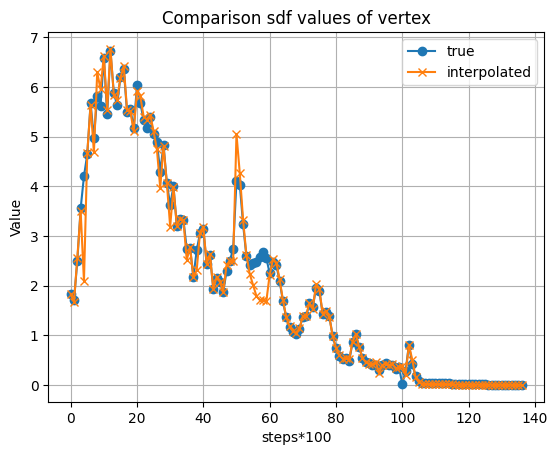

In [11]:
import matplotlib.pyplot as plt

def plot_values(list1, list2, title='Plot of Two Lists', xlabel='X-axis', ylabel='Y-axis', list1_label='List 1', list2_label='List 2'):
    plt.figure()
    
    # Plot the first list
    plt.plot(list1, label=list1_label, marker='o')
    
    # Plot the second list
    plt.plot(list2, label=list2_label, marker='x')
    
    # Add title and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Add a legend
    plt.legend()
    #plt.ylim(-2,10)
    # Show the plot
    plt.grid(True)
    plt.show()

plot_values(true_vertex_values, interpolated_vertex_values, title='Comparison sdf values of vertex', xlabel='steps*100', ylabel='Value', list1_label='true', list2_label='interpolated')


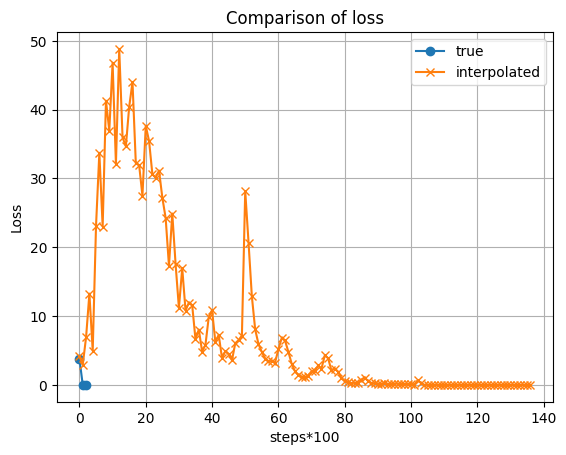

In [14]:
plot_values(true_loss_values, interpolated_loss_values, title='Comparison of loss', xlabel='steps*100', ylabel='Loss', list1_label='true', list2_label='interpolated')
